In [ ]:
#pip install transformers

In [ ]:
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
from transformers import BertModel, BertTokenizerFast, AdamW
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
import nltk

In [ ]:
MODEL_PATH = "bert-base-uncased"

In [ ]:
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2024-05-22 09:30:13--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   143MB/s    in 0.3s    

2024-05-22 09:30:15 (143 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2024-05-22 09:30:15--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       1

In [ ]:
num_questions = 0
num_posible = 0
num_imposible = 0

In [ ]:
def get_data(path):
  with open(path, 'rb') as f:
    raw_data = json.load(f)

  contexts = []
  questions = []
  answers = []
  num_q = 0
  num_pos = 0
  num_imp = 0

  for group in raw_data['data']:
    for paragraph in group['paragraphs']:
      context = paragraph['context']
      for qa in paragraph['qas']:
        question = qa['question']
        num_q  = num_q  +1
        if qa['is_impossible'] == True:
            num_imp = num_imp +1
        else:
            num_pos = num_pos +1
        if qa['is_impossible'] == True:
          contexts.append(context.lower())
          questions.append(question.lower())
          answers.append({'text': '', 'answer_start':-1, 'answer_end':-1})
        else:
            for answer in qa['answers']:
              contexts.append(context.lower())
              questions.append(question.lower())
              answers.append(answer)

  return num_q, num_pos, num_imp, contexts, questions, answers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
num_q = 0
num_pos = 0
num_imp = 0
train_contexts = []
train_questions = []
train_answers = []

In [ ]:
num_q, num_pos, num_imp, train_contexts, train_questions, train_answers = get_data('/content/drive/MyDrive/OELP_BERT/BERT_SQuad/squad+15k.json')
num_questions  = num_q
num_posible = num_pos
num_imposible  = num_imp

TypeError: list indices must be integers or slices, not str

In [ ]:
def get_data_2(path):
  with open(path, 'rb') as f:
    raw_data = json.load(f)

  contexts = []
  questions = []
  answers = []
  num_q = 0
  num_pos = 0
  num_imp = 0

  for group in raw_data['data']:
    for paragraph in group['paragraphs']:
      context = paragraph['context']
      for qa in paragraph['qas']:
        question = qa['question']
        num_q  = num_q  +1
        if qa['is_impossible'] == True:
            num_imp = num_imp +1
        else:
            num_pos = num_pos +1
        for answer in qa['answers']:
          contexts.append(context.lower())
          questions.append(question.lower())
          answers.append(answer)

  return num_q, num_pos, num_imp, contexts, questions, answers

In [ ]:
dataset_file = open('train-v2.0.json')

new_data = json.load(dataset_file)

In [ ]:
num_q = 0
num_pos = 0
num_imp = 0

new_answers = []
new_answer_start = []

for i in range(len(new_data)):
  train_contexts.append(new_data[i]["sentence"])
  train_questions.append(new_data[i]['question'])
  new_answers.append(new_data[i]['answer'])
  new_answer_start.append(new_data[i]['answer_start'])
  train_answers.append({ 'text': new_answers[-1], 'answer_start': new_answer_start[-1]})

  num_q += 1
  if(0):
    num_imp += 1
  else:
    num_pos += 1

num_questions += num_q
num_posible += num_pos
num_imposible += num_imp


KeyError: 0

In [ ]:
print(train_questions[0:10])
print(train_answers[0:10])

['when did beyonce start becoming popular?', 'what areas did beyonce compete in when she was growing up?', "when did beyonce leave destiny's child and become a solo singer?", 'in what city and state did beyonce  grow up? ', 'in which decade did beyonce become famous?', 'in what r&b group was she the lead singer?', 'what album made her a worldwide known artist?', "who managed the destiny's child group?", 'when did beyoncé rise to fame?', "what role did beyoncé have in destiny's child?"]
[{'text': 'in the late 1990s', 'answer_start': 269}, {'text': 'singing and dancing', 'answer_start': 207}, {'text': '2003', 'answer_start': 526}, {'text': 'Houston, Texas', 'answer_start': 166}, {'text': 'late 1990s', 'answer_start': 276}, {'text': "Destiny's Child", 'answer_start': 320}, {'text': 'Dangerously in Love', 'answer_start': 505}, {'text': 'Mathew Knowles', 'answer_start': 360}, {'text': 'late 1990s', 'answer_start': 276}, {'text': 'lead singer', 'answer_start': 290}]


In [ ]:
# num_q, num_pos, num_imp, valid_contexts, valid_questions, valid_answers = get_data('dev-v2.0.json')
# num_questions  = num_questions + num_q
# num_posible = num_posible + num_pos
# num_imposible = num_imposible  + num_imp

# print(f"Total number of questions: {num_questions}")
# print(f"Total number of Answerable questions: {num_posible}")
# print(f"Total number of impossible questions: {num_imposible}")

In [ ]:
print(len(train_answers))

145936


In [ ]:
for i in range(len(train_questions)):
  tokens = nltk.word_tokenize(train_questions[i].lower())
  tagged_tokens = nltk.pos_tag(tokens)

  if "when" in train_questions[i]:
    train_questions[i] += "<Answer is time related>"
  if "why" in train_questions[i]:
    train_questions[i] += "<Answer is a reason>"
  if "how much" in train_questions[i]:
    train_questions[i] += "<Answer is a quantity>"
  if "which" in train_questions[i]:
    train_questions[i] += "<Answer is one of the objects>"
  if "where" in train_questions[i]:
    train_questions[i] += "<Answer is a place>"
  if "percentage" or "amount" in train_questions[i]:
    train_questions[i] += "<Answer is a quantity>"
  if "who" in train_questions[i]:
    train_questions[i] += "<Answer is a person>"
  if any(tag in ["JJR", "JJS", "RBR", "RBS"] for _, tag in tagged_tokens):
    train_contexts[i] += "(Answer involves a comparison or numerical aspect)"
  for j, (_, tag) in enumerate(tagged_tokens):
    if tag in ["JJR", "JJS", "RBR", "RBS"]:
      txt_split = train_questions[i].split()
      txt_split.insert(j+1, '<comparative token>')
      new_str = ""
      new_str = new_str.join(txt_split)
      train_question[i] = new_str

# for i in range(len(valid_questions)):
#   tokens = nltk.word_tokenize(valid_questions[i].lower())
#   tagged_tokens = nltk.pos_tag(tokens)

#   if "when" in valid_questions[i].lower():
#     valid_contexts[i] += "(Answer is time related)"
#   if "why" in valid_questions[i].lower():
#     valid_contexts[i] += "(Answer is a reason)"
#   if "how much" in valid_questions[i].lower():
#     valid_contexts[i] += "(Answer is a quantity)"
#   if "which" in valid_questions[i].lower():
#     valid_contexts[i] += "(Answer is one of the objects)"
#   if "where" in valid_questions[i].lower():
#     valid_contexts[i] += "(Answer is a place)"
#   if "percentage" or "amount" in valid_questions[i].lower():
#     valid_contexts[i] += "(Answer is a quantity)"
#   if "who" in valid_questions[i].lower():
#     valid_contexts[i] += "(Answer is a person)"
#   if any(tag in ["JJR", "JJS", "RBR", "RBS"] for _, tag in nltk.pos_tag(tokens)):
#     valid_contexts[i] += "(Answer involves a comparison or numerical aspect)"


In [ ]:
# print(valid_questions[0:10])
# print(valid_answers[0:10])

In [ ]:
def add_answer_end(answers, contexts):
  for answer, context in zip(answers, contexts):
    answer['text'] = answer['text'].lower()
    answer['answer_end'] = answer['answer_start'] + len(answer['text'])

add_answer_end(train_answers, train_contexts)
# add_answer_end(valid_answers, valid_contexts)

In [ ]:

print(f"Context: {train_contexts[0]}")
print(f"Question: {train_questions[0]}")
print(f"Answer: {train_answers[0]}")

Context: beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ bee-yon-say) (born september 4, 1981) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r&b girl-group destiny's child. managed by her father, mathew knowles, the group became one of the world's best-selling girl groups of all time. their hiatus saw the release of beyoncé's debut album, dangerously in love (2003), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number-one singles "crazy in love" and "baby boy".
Question: when did beyonce start becoming popular?
Answer: {'text': 'in the late 1990s', 'answer_start': 269, 'answer_end': 286}


In [ ]:
# test_rec = 30
# print(f"Context: {valid_contexts[test_rec]}")
# print(f"Question: {valid_questions[test_rec]}")
# print(f"Answer: {valid_answers[test_rec]}")

851


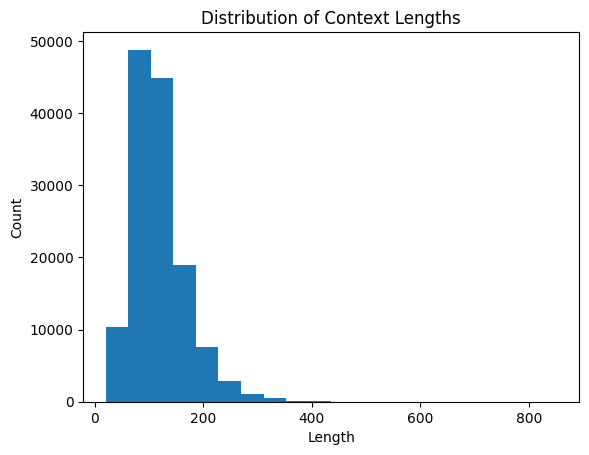

In [ ]:
token_lens = []

for txt in train_contexts:
    txt = txt.strip()
    token_lens.append(len(txt.split(' ')))


print(max(token_lens))

plt.hist(token_lens,  bins=20)
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Context Lengths');

40
135319


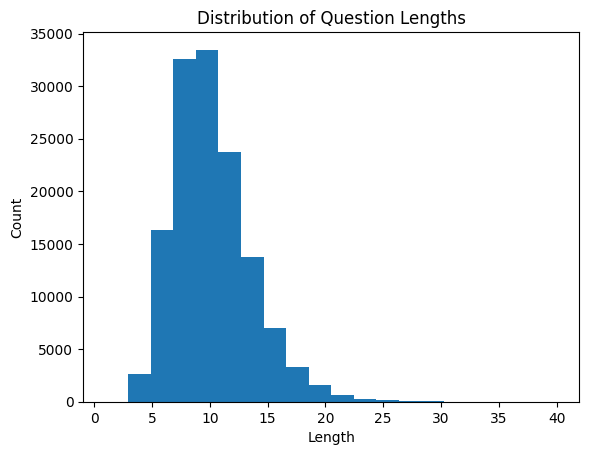

In [ ]:
token_lens2 = []

for txt in train_questions:
    txt = txt.strip()
    token_lens2.append(len(txt.split(' ')))


print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Question Lengths');

In [ ]:
MAX_LENGTH = 250

In [ ]:
tokenizerFast = BertTokenizerFast.from_pretrained(MODEL_PATH)

train_encodings_fast = tokenizerFast(train_questions, train_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)
# valid_encodings_fast = tokenizerFast(valid_questions,valid_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
type(train_encodings_fast)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
# print(train_encodings_fast.keys())
# print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['input_ids'][1]))

135319
250


In [ ]:
print(train_encodings_fast['input_ids'][1])
print(tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(train_encodings_fast['input_ids'][1])))

[101, 2054, 2752, 2106, 20773, 5566, 1999, 2043, 2016, 2001, 3652, 2039, 1029, 102, 20773, 21025, 19358, 22815, 1011, 5708, 1006, 1013, 12170, 23432, 29715, 3501, 29678, 12325, 29685, 1013, 10506, 1011, 10930, 2078, 1011, 2360, 1007, 1006, 2141, 2244, 1018, 1010, 3261, 1007, 2003, 2019, 2137, 3220, 1010, 6009, 1010, 2501, 3135, 1998, 3883, 1012, 2141, 1998, 2992, 1999, 5395, 1010, 3146, 1010, 2016, 2864, 1999, 2536, 4823, 1998, 5613, 6479, 2004, 1037, 2775, 1010, 1998, 3123, 2000, 4476, 1999, 1996, 2397, 4134, 2004, 2599, 3220, 1997, 1054, 1004, 1038, 2611, 1011, 2177, 10461, 1005, 1055, 2775, 1012, 3266, 2011, 2014, 2269, 1010, 25436, 22815, 1010, 1996, 2177, 2150, 2028, 1997, 1996, 2088, 1005, 1055, 2190, 1011, 4855, 2611, 2967, 1997, 2035, 2051, 1012, 2037, 14221, 2387, 1996, 2713, 1997, 20773, 1005, 1055, 2834, 2201, 1010, 20754, 1999, 2293, 1006, 2494, 1007, 1010, 2029, 2511, 2014, 2004, 1037, 3948, 3063, 4969, 1010, 3687, 2274, 8922, 2982, 1998, 2956, 1996, 4908, 2980, 2531, 2193

In [ ]:
type(train_answers[0]['text'])
train_answers[0].keys()

dict_keys(['text', 'answer_start', 'answer_end'])

In [ ]:
def ret_Answer_start_and_end_train(idx):     #finds index of answer from context
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(train_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(train_encodings_fast['input_ids'][idx]) -  len(answer_encoding_fast['input_ids']) ):
        match = True
        i=0
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):

            if (answer_encoding_fast['input_ids'][i] != train_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [ ]:
test_rec=92

z,x = ret_Answer_start_and_end_train(test_rec)
print("z and x are")
print(z, x)

predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

z and x are
0 0

split with luckett and rober
[CLS] what event caused beyonce's depression? [SEP] letoya luckett and roberson became unhappy with mathew's managing of the band and eventually were replaced by farrah franklin and michelle williams. beyonce experienced depression following the split with luckett and roberson after being publicly blamed by the media, critics, and blogs for its cause. her long - standing boyfriend left her at this time. the depression was so severe it lasted for a couple of years, during which she occasionally kept herself in her bedroom for days and refused to eat anything. beyonce stated that she struggled to speak about her depression because destiny's child had just won their first grammy award and she feared no one would take her seriously. beyonce would later speak of her mother as the person who helped her fight it. franklin was dismissed, leaving just beyonce, rowland, and williams. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [ ]:
test_rec=1

z,x = ret_Answer_start_and_end_train(test_rec)
print("z and x are")
print(z, x)

predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

z and x are
68 71
singing and dancing
singing and dancing
[CLS] what areas did beyonce compete in when she was growing up? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny's child. managed by her father, mathew knowles, the group became one of the world's best - selling girl groups of all time. their hiatus saw the release of beyonce's debut album, dangerously in love ( 2003 ), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number - one singles " crazy in love " and " baby boy ". [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
print(train_encodings_fast.keys())
# print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
135319


In [ ]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(train_encodings_fast['input_ids'])):
    s, e = ret_Answer_start_and_end_train(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1


train_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

1379


In [ ]:
print(train_encodings_fast.keys())
# print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
135319


In [ ]:
test_rec = 1
print(train_encodings_fast['start_positions'][test_rec])
print(train_encodings_fast['end_positions'][test_rec])
predict_answer_tokens = train_encodings_fast.input_ids[test_rec][train_encodings_fast['start_positions'][test_rec] : train_encodings_fast['end_positions'][test_rec]]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

68
71
singing and dancing
singing and dancing
[CLS] what areas did beyonce compete in when she was growing up? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny's child. managed by her father, mathew knowles, the group became one of the world's best - selling girl groups of all time. their hiatus saw the release of beyonce's debut album, dangerously in love ( 2003 ), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number - one singles " crazy in love " and " baby boy ". [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
# def ret_Answer_start_and_end_valid(idx):         #finds index of answer from context
#     ret_start = 0
#     ret_end = 0
#     answer_encoding_fast = tokenizerFast(valid_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
#     for a in range( len(valid_encodings_fast['input_ids'][idx])  -  len(answer_encoding_fast['input_ids'])   ):
#         match = True
#         for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
#             if (answer_encoding_fast['input_ids'][i] != valid_encodings_fast['input_ids'][idx][a + i]):
#                 match = False
#                 break
#         if match:
#             ret_start = a+1
#             ret_end = a+i+1
#             break
#     return(ret_start, ret_end)

In [ ]:
# start_positions = []    #updating start and end positions
# end_positions = []
# ctr = 0
# for h in range(len(valid_encodings_fast['input_ids']) ):
#     s, e = ret_Answer_start_and_end_valid(h)
#     start_positions.append(s)
#     end_positions.append(e)
#     if s==0:
#         ctr = ctr + 1


# valid_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
# print(ctr)

In [ ]:
# test_rec=2

# z,x = ret_Answer_start_and_end_valid(test_rec)

# predict_answer_tokens = valid_encodings_fast.input_ids[test_rec][z : x]
# print(tokenizerFast.decode(predict_answer_tokens))
# print(valid_answers[test_rec]['text'])
# print(tokenizerFast.decode(valid_encodings_fast['input_ids'][test_rec]))

In [ ]:
print(train_encodings_fast.keys())
# print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['start_positions']))
print(len(train_encodings_fast['end_positions']))
# print(len(valid_encodings_fast['input_ids']))
# print(len(valid_encodings_fast['start_positions']))
# print(len(valid_encodings_fast['end_positions']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
135319
135319
135319


In [ ]:
tokenizerFast.decode(train_encodings_fast['input_ids'][0])

'[CLS] when did beyonce start becoming popular? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny\'s child. managed by her father, mathew knowles, the group became one of the world\'s best - selling girl groups of all time. their hiatus saw the release of beyonce\'s debut album, dangerously in love ( 2003 ), which established her as a solo artist worldwide, earned five grammy awards and featured the billboard hot 100 number - one singles " crazy in love " and " baby boy ". [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [ ]:
test_row= 0
print(train_contexts[test_row][train_answers[test_row]['answer_start']:train_answers[test_row]['answer_end']])

in the late 1990s


In [ ]:
answer_start_index = 0
answer_end_index = 100

predict_answer_tokens = train_encodings_fast.input_ids[0][answer_start_index : answer_end_index]
tokenizerFast.decode(predict_answer_tokens)

"[CLS] when did beyonce start becoming popular? [SEP] beyonce giselle knowles - carter ( / biːˈjɒnseɪ / bee - yon - say ) ( born september 4, 1981 ) is an american singer, songwriter, record producer and actress. born and raised in houston, texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of r & b girl - group destiny's child. managed by her father, mathew"

In [ ]:
class InputDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][i]),
            'token_type_ids': torch.tensor(self.encodings['token_type_ids'][i]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][i]),
            'start_positions': torch.tensor(self.encodings['start_positions'][i]),
            'end_positions': torch.tensor(self.encodings['end_positions'][i])
        }
    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
bert_model = BertModel.from_pretrained(MODEL_PATH)
class QAModel(nn.Module):
    def __init__(self):
        super(QAModel, self).__init__()
        self.bert = bert_model
        self.drop_out = nn.Dropout(0.1)
        self.l1 = nn.Linear(768 * 2, 768 * 2)
        self.l2 = nn.Linear(768 * 2, 2)
        self.linear_relu_stack = nn.Sequential(
            self.drop_out,
            self.l1,
            nn.LeakyReLU(),
            self.l2
        )

    def forward(self, input_ids, attention_mask, token_type_ids):
        model_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)
        hidden_states = model_output[2]
        out = torch.cat((hidden_states[-1], hidden_states[-3]), dim=-1)
        logits = self.linear_relu_stack(out)

        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
choice_list = [0, 1, 2, 3, 4]
print(len(train_encodings_fast['input_ids']))
valid_encodings_split = {i: [] for i in range(5)}
train_encodings_split = {i: [] for i in range(5)}
import random
total_valids = 5*(int(len(train_encodings_fast['input_ids'])/5))
valid_index_list = [i for i in range(len(train_encodings_fast['input_ids']))]
random.shuffle(valid_index_list)
for i in range(total_valids):
  valid_encodings_split[int(((i)/total_valids)*5)].append(valid_index_list[i])
for i in range(5):
  for j in valid_encodings_split[i]:
    for k in range(5):
      if k!=i:
        train_encodings_split[k].append(j)

135319


In [ ]:
#save the encoding file
file_str = ""
# for i in range(4):
#   for ele in train_encodings_split[i]:
#     file_str += ele
#     file_str += ","
#   file_str += "\n"
for i in range(5):
  for ele in valid_encodings_split[i]:
    file_str += str(ele)
    file_str += ","
  file_str += "\n"
with open("/content/drive/MyDrive/OELP_BERT/BERT_SQuad/trial.txt", "w") as writefile:
  writefile.write(file_str)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
model = QAModel()

In [ ]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)/2
    return total_loss

def focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma):

    smax = nn.Softmax(dim=1)
    probs_start = smax(start_logits)
    inv_probs_start = 1 - probs_start
    probs_end = smax(end_logits)
    inv_probs_end = 1 - probs_end

    lsmax = nn.LogSoftmax(dim=1)
    log_probs_start = lsmax(start_logits)
    log_probs_end = lsmax(end_logits)

    nll = nn.NLLLoss()

    fl_start = nll(torch.pow(inv_probs_start, gamma)* log_probs_start, start_positions)
    fl_end = nll(torch.pow(inv_probs_end, gamma)*log_probs_end, end_positions)

    return ((fl_start + fl_end)/2)

In [ ]:
optim = AdamW(model.parameters(), lr=2e-5, weight_decay=2e-2)
scheduler = ExponentialLR(optim, gamma=0.9)
total_acc = []
total_loss = []

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(model, dataloader, epoch):
    model = model.train()
    losses = []
    acc = []
    ctr = 0
    batch_tracker = 0
    for batch in tqdm(dataloader, desc = 'Running Epoch '):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
        loss = focal_loss_fn(out_start, out_end, start_positions, end_positions,1)
        losses.append(loss.item())
        loss.backward()
        optim.step()
        #print(out_start)

        # for iter in range(16):
        #   print(tokenizerFast.decode(input_ids[iter]))

        # print(out_start.size())
        start_pred = torch.argmax(out_start, dim=1)
        end_pred = torch.argmax(out_end, dim=1)
        # print("\n")
        #print((type(start_positions)))
        #print(type(start_pred))

        # for iter in range(16):
        #   print("pred")
        #   print(tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(input_ids[iter][start_pred[iter] : end_pred[iter]])))
        #   print("true ans")
        #   print(tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(input_ids[iter][start_positions[iter] : end_positions[iter]])))

        #print(start_pred)
        #print(start_positions)

        acc.append(((start_pred == start_positions).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_positions).sum()/len(end_pred)).item())

        #print(f"acc1 is {acc[-2]} acc2 is {acc[-1]}")
        # print("\n")

        batch_tracker = batch_tracker + 1
        if batch_tracker==250 and epoch==1:
            total_acc.append(sum(acc)/len(acc))
            loss_avg = sum(losses)/len(losses)
            total_loss.append(loss_avg)
            batch_tracker = 0
    scheduler.step()
    ret_acc = sum(acc)/len(acc)
    ret_loss = sum(losses)/len(losses)
    return(ret_acc, ret_loss)

In [ ]:
def eval_model(model, dataloader):
    model = model.eval()
    losses = []
    acc = []
    ctr = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc = 'Running Evaluation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)

            out_start, out_end = model(input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)

            start_pred = torch.argmax(out_start, dim=1)
            end_pred = torch.argmax(out_end, dim=1)

            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
        ret_acc = sum(acc)/len(acc)
        ret_loss = 0
    return(ret_acc)

In [ ]:
EPOCHS = 5
curr_epoch = 0
model.to(device)

QAModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [ ]:
for epoch in range(EPOCHS):
  actual_train_encoding = {
      'input_ids' : [],
      'token_type_ids' : [],
      'attention_mask' : [],
      'start_positions' : [],
      'end_positions' : []
  }
  actual_valid_encoding = {
      'input_ids' : [],
      'token_type_ids' : [],
      'attention_mask' : [],
      'start_positions' : [],
      'end_positions' : []
  }

  for index in range(len(train_encodings_split[epoch])):
    actual_train_encoding['input_ids'].append(train_encodings_fast['input_ids'][index])
    actual_train_encoding['token_type_ids'].append(train_encodings_fast['token_type_ids'][index])
    actual_train_encoding['attention_mask'].append(train_encodings_fast['attention_mask'][index])
    actual_train_encoding['start_positions'].append(train_encodings_fast['start_positions'][index])
    actual_train_encoding['end_positions'].append(train_encodings_fast['end_positions'][index])

  for index in range(len(valid_encodings_split[epoch])):
    actual_valid_encoding['input_ids'].append(train_encodings_fast['input_ids'][index])
    actual_valid_encoding['token_type_ids'].append(train_encodings_fast['token_type_ids'][index])
    actual_valid_encoding['attention_mask'].append(train_encodings_fast['attention_mask'][index])
    actual_valid_encoding['start_positions'].append(train_encodings_fast['start_positions'][index])
    actual_valid_encoding['end_positions'].append(train_encodings_fast['end_positions'][index])

  #print(actual_train_encoding)

  train_dataset = InputDataset(actual_train_encoding)
  valid_dataset = InputDataset(actual_valid_encoding)
  train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
  valid_data_loader = DataLoader(valid_dataset, batch_size=32)

  curr_epoch += 1
  print(f"current epoch is {curr_epoch}")
  train_acc, train_loss = train_epoch(model, train_data_loader, epoch+1)
  print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
  val_acc = eval_model(model, valid_data_loader)
  print(f"Validation Accuracy: {val_acc}")
  torch.save(model.state_dict(), f'/content/drive/MyDrive/OELP_BERT/BERT_SQuad/SQuad_with_ua_5k_augment_{epoch}.hdf5')

current epoch is 1


Running Epoch : 100%|██████████| 6766/6766 [1:27:21<00:00,  1.29it/s]


Train Accuracy: 0.5586341634643808      Train Loss: 1.2181516252887556


Running Evaluation: 100%|██████████| 846/846 [07:12<00:00,  1.96it/s]


Validation Accuracy: 0.766623946474799
current epoch is 2


Running Epoch : 100%|██████████| 6766/6766 [1:27:22<00:00,  1.29it/s]


Train Accuracy: 0.7127888215617108      Train Loss: 0.6695512511098205


Running Evaluation: 100%|██████████| 846/846 [07:12<00:00,  1.96it/s]


Validation Accuracy: 0.8574477721613349
current epoch is 3


Running Epoch :  25%|██▍       | 1686/6766 [21:45<1:05:36,  1.29it/s]

In [ ]:
scheduler.get_last_lr()

In [ ]:
plt.plot(total_acc, color='blue')
plt.ylabel('Accuracy')
plt.xlabel('Runs->')
plt.title("Total Train Accuracy over time");

In [ ]:
plt.plot(total_loss, color='red')
plt.ylabel('Loss')
plt.xlabel('Runs->')
plt.title("Total Train Loss over time");

In [ ]:
def get_answer(question, context):
    inputs = tokenizerFast.encode_plus(question, context, return_tensors='pt').to(device)
    with torch.no_grad():
        output_start, output_end = model(**inputs)

        answer_start = torch.argmax(output_start)
        answer_end = torch.argmax(output_end)

        answer = tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

        return(answer)

In [ ]:
test_rec = 0

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

In [ ]:
test_rec = 15

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

In [ ]:
test_rec = 28

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

In [ ]:
test_rec = 2000

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

In [ ]:
test_rec = 4000

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

In [ ]:
context = "I am Utsav Patel. I just completed my fine-tuning of the BERT base uncased model. I am glad that it works after 5 attempts."
question = "How many attempts did it take to fine-tune ?"
print(f"Predicted Answer: {get_answer(question, context)}")

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/OELP_Augment.hdf5')

In [ ]:
EPOCHS = 3
curr_epoch = 0
fold_tr_acc = []   #to store the accuracies
fold_val_acc = []
for i in range(5):
  fold_tr_acc.append([])
  fold_val_acc.append([])

In [ ]:
for ele in fold_tr_acc:
  print(ele)

[]
[]
[]
[]
[]


In [ ]:
for fold in range(5):    #for each fold, we repeat the training for n epochs
  print(f"CURRENT FOLD IS {fold+1}")
  for epoch in range(EPOCHS):        #training for n epochs, for 1 fold
    curr_epoch += 1
    print(f"current epoch is {curr_epoch}")
    fold_tr_acc[fold].append(curr_epoch)
    fold_val_acc[fold].append(curr_epoch)
  for ele in fold_tr_acc:
    print(ele)

CURRENT FOLD IS 1
current epoch is 1
current epoch is 2
current epoch is 3
[1, 2, 3]
[]
[]
[]
[]
CURRENT FOLD IS 2
current epoch is 4
current epoch is 5
current epoch is 6
[1, 2, 3]
[4, 5, 6]
[]
[]
[]
CURRENT FOLD IS 3
current epoch is 7
current epoch is 8
current epoch is 9
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[]
[]
CURRENT FOLD IS 4
current epoch is 10
current epoch is 11
current epoch is 12
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 11, 12]
[]
CURRENT FOLD IS 5
current epoch is 13
current epoch is 14
current epoch is 15
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 11, 12]
[13, 14, 15]


In [ ]:
for ele in fold_tr_acc:
  print(ele)

[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 11, 12]
[13, 14, 15]
